In [2]:
!pip install numpy opencv-python

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import glob
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import gc
import torch
import psutil
import numpy as np
import pandas as pd

In [4]:
csv_path = '../input/dlproject/mimic-cxr-2.0.0-chexpert.csv'
df = pd.read_csv(csv_path)
print(df.head())

   subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0    10000032  50414267          NaN           NaN            NaN    NaN   
1    10000032  53189527          NaN           NaN            NaN    NaN   
2    10000032  53911762          NaN           NaN            NaN    NaN   
3    10000032  56699142          NaN           NaN            NaN    NaN   
4    10000764  57375967          NaN           NaN            1.0    NaN   

   Enlarged Cardiomediastinum  Fracture  Lung Lesion  Lung Opacity  \
0                         NaN       NaN          NaN           NaN   
1                         NaN       NaN          NaN           NaN   
2                         NaN       NaN          NaN           NaN   
3                         NaN       NaN          NaN           NaN   
4                         NaN       NaN          NaN           NaN   

   No Finding  Pleural Effusion  Pleural Other  Pneumonia  Pneumothorax  \
0         1.0               NaN            NaN 

In [5]:
filtered_df = df[df['subject_id'].astype(str).str.startswith('10')]
count = len(filtered_df)

print(f"Number of samples with study_id starting with 'p10': {count}")

Number of samples with study_id starting with 'p10': 22197


In [6]:
label_columns = filtered_df.columns.difference(['subject_id', 'study_id'])
label_counts = {label: filtered_df[label].value_counts() for label in label_columns}

for label, counts in label_counts.items():
    print(f"Counts for {label}:")
    print(counts)
    print()  

Counts for Atelectasis:
Atelectasis
 1.0    4535
-1.0    1008
 0.0     130
Name: count, dtype: int64

Counts for Cardiomegaly:
Cardiomegaly
 1.0    4493
 0.0    1472
-1.0     623
Name: count, dtype: int64

Counts for Consolidation:
Consolidation
 1.0    1098
 0.0     755
-1.0     389
Name: count, dtype: int64

Counts for Edema:
Edema
 1.0    2614
 0.0    2520
-1.0    1310
Name: count, dtype: int64

Counts for Enlarged Cardiomediastinum:
Enlarged Cardiomediastinum
-1.0    914
 1.0    695
 0.0    499
Name: count, dtype: int64

Counts for Fracture:
Fracture
 1.0    464
 0.0     80
-1.0     49
Name: count, dtype: int64

Counts for Lung Lesion:
Lung Lesion
 1.0    614
-1.0     97
 0.0     84
Name: count, dtype: int64

Counts for Lung Opacity:
Lung Opacity
 1.0    5009
-1.0     387
 0.0     294
Name: count, dtype: int64

Counts for No Finding:
No Finding
1.0    7267
Name: count, dtype: int64

Counts for Pleural Effusion:
Pleural Effusion
 1.0    5311
 0.0    2612
-1.0     572
Name: count, dt

In [7]:
p10_subject_ids = df[df['subject_id'].astype(str).str.startswith('10')]['subject_id'].unique()
p10_patient_df = df[df['subject_id'].isin(p10_subject_ids)]

num_rows_to_select = int(len(p10_patient_df) * 0.5) 
p10_sampled_df = p10_patient_df.iloc[:num_rows_to_select] 

print("Filtered DataFrame for the first 50% of P10 observations:")
print(p10_sampled_df)


Filtered DataFrame for the first 50% of P10 observations:
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0        10000032  50414267          NaN           NaN            NaN    NaN   
1        10000032  53189527          NaN           NaN            NaN    NaN   
2        10000032  53911762          NaN           NaN            NaN    NaN   
3        10000032  56699142          NaN           NaN            NaN    NaN   
4        10000764  57375967          NaN           NaN            1.0    NaN   
...           ...       ...          ...           ...            ...    ...   
11093    10498545  56789676          NaN           NaN            NaN    NaN   
11094    10498557  52457766          NaN           1.0            NaN   -1.0   
11095    10498557  59910967          NaN           0.0            NaN    NaN   
11096    10498667  52430077          NaN           NaN            NaN    NaN   
11097    10498687  53217608          NaN           NaN        

In [8]:
label_columns = p10_sampled_df.columns.difference(['subject_id', 'study_id', 'study_id'])
for col in label_columns:
    p10_sampled_df[col] = p10_sampled_df[col].replace(-1, 0.0)

/tmp/ipykernel_23/1538174521.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p10_sampled_df[col] = p10_sampled_df[col].replace(-1, 0.0)


In [9]:
columns_to_check = p10_sampled_df.columns[2:]  
rows_with_all_zeros_or_nan = p10_sampled_df[
    p10_sampled_df[columns_to_check].isna().all(axis=1)
]

count_all_zeros_or_nan = rows_with_all_zeros_or_nan.shape[0]

print(f"Number of rows where all specified columns are zero or NaN: {count_all_zeros_or_nan}")
print(rows_with_all_zeros_or_nan)


Number of rows where all specified columns are zero or NaN: 113
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
93       10002428  57321224          NaN           NaN            NaN    NaN   
134      10003019  59829602          NaN           NaN            NaN    NaN   
206      10005858  58867217          NaN           NaN            NaN    NaN   
347      10012292  54533628          NaN           NaN            NaN    NaN   
378      10013643  51129178          NaN           NaN            NaN    NaN   
...           ...       ...          ...           ...            ...    ...   
10721    10477480  57300483          NaN           NaN            NaN    NaN   
10786    10481190  56890865          NaN           NaN            NaN    NaN   
10893    10488182  56940171          NaN           NaN            NaN    NaN   
10948    10491172  55992174          NaN           NaN            NaN    NaN   
11021    10495509  50908760          NaN           NaN  

In [10]:
columns_to_check = p10_sampled_df.columns[2:]  
p10_sampled_df = p10_sampled_df.dropna(subset=columns_to_check, how='all')
remaining_row_count = p10_sampled_df.shape[0]

print(f"Number of rows remaining after dropping rows with all specified columns as NaN: {remaining_row_count}")
print(p10_sampled_df)


Number of rows remaining after dropping rows with all specified columns as NaN: 10985
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0        10000032  50414267          NaN           NaN            NaN    NaN   
1        10000032  53189527          NaN           NaN            NaN    NaN   
2        10000032  53911762          NaN           NaN            NaN    NaN   
3        10000032  56699142          NaN           NaN            NaN    NaN   
4        10000764  57375967          NaN           NaN            1.0    NaN   
...           ...       ...          ...           ...            ...    ...   
11093    10498545  56789676          NaN           NaN            NaN    NaN   
11094    10498557  52457766          NaN           1.0            NaN    0.0   
11095    10498557  59910967          NaN           0.0            NaN    NaN   
11096    10498667  52430077          NaN           NaN            NaN    NaN   
11097    10498687  53217608       

In [11]:
no_finding_column = "No Finding" 
columns_to_check = p10_sampled_df.columns.difference([no_finding_column, 'subject_id', 'study_id'])

rows_with_no_finding_only = p10_sampled_df[
    (p10_sampled_df[no_finding_column] == 1) & 
    (p10_sampled_df[columns_to_check].isna().all(axis=1))
]

count_no_finding_only = rows_with_no_finding_only.shape[0]

print(f"Number of instances where only 'No Finding' is 1 and all other columns are NaN: {count_no_finding_only}")
print(rows_with_no_finding_only)


Number of instances where only 'No Finding' is 1 and all other columns are NaN: 2417
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0        10000032  50414267          NaN           NaN            NaN    NaN   
1        10000032  53189527          NaN           NaN            NaN    NaN   
2        10000032  53911762          NaN           NaN            NaN    NaN   
3        10000032  56699142          NaN           NaN            NaN    NaN   
5        10000898  50771383          NaN           NaN            NaN    NaN   
...           ...       ...          ...           ...            ...    ...   
11089    10498472  57677356          NaN           NaN            NaN    NaN   
11091    10498545  50967855          NaN           NaN            NaN    NaN   
11092    10498545  56248377          NaN           NaN            NaN    NaN   
11093    10498545  56789676          NaN           NaN            NaN    NaN   
11096    10498667  52430077        

In [12]:
columns_to_check = p10_sampled_df.columns[3:]  
no_finding_col = 'No Finding'  

no_finding_condition = p10_sampled_df[no_finding_col] == 1
other_columns = [col for col in columns_to_check if col != no_finding_col]
other_columns_condition = p10_sampled_df[other_columns].applymap(lambda x: pd.isna(x) or x == 0).all(axis=1)

final_condition = no_finding_condition & other_columns_condition
rows_with_no_finding_only = p10_sampled_df[final_condition]
count_no_finding_only = rows_with_no_finding_only.shape[0]

print(f"Number of rows where 'No Finding' is 1, and all other columns are NaN or 0: {count_no_finding_only}")
print(rows_with_no_finding_only)

Number of rows where 'No Finding' is 1, and all other columns are NaN or 0: 3092
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0        10000032  50414267          NaN           NaN            NaN    NaN   
1        10000032  53189527          NaN           NaN            NaN    NaN   
2        10000032  53911762          NaN           NaN            NaN    NaN   
3        10000032  56699142          NaN           NaN            NaN    NaN   
5        10000898  50771383          NaN           NaN            NaN    NaN   
...           ...       ...          ...           ...            ...    ...   
11089    10498472  57677356          NaN           NaN            NaN    NaN   
11091    10498545  50967855          NaN           NaN            NaN    NaN   
11092    10498545  56248377          NaN           NaN            NaN    NaN   
11093    10498545  56789676          NaN           NaN            NaN    NaN   
11096    10498667  52430077          Na

/tmp/ipykernel_23/1140664349.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  other_columns_condition = p10_sampled_df[other_columns].applymap(lambda x: pd.isna(x) or x == 0).all(axis=1)


In [13]:
label_columns = p10_sampled_df.columns.difference(['subject_id', 'study_id'])
label_counts = {label: p10_sampled_df[label].value_counts() for label in label_columns}

for label, counts in label_counts.items():
    print(f"Counts for {label}:")
    print(counts)
    print()  

Counts for Atelectasis:
Atelectasis
1.0    2258
0.0     533
Name: count, dtype: int64

Counts for Cardiomegaly:
Cardiomegaly
1.0    2276
0.0    1034
Name: count, dtype: int64

Counts for Consolidation:
Consolidation
0.0    560
1.0    557
Name: count, dtype: int64

Counts for Edema:
Edema
0.0    1863
1.0    1347
Name: count, dtype: int64

Counts for Enlarged Cardiomediastinum:
Enlarged Cardiomediastinum
0.0    724
1.0    358
Name: count, dtype: int64

Counts for Fracture:
Fracture
1.0    255
0.0     66
Name: count, dtype: int64

Counts for Lung Lesion:
Lung Lesion
1.0    303
0.0     87
Name: count, dtype: int64

Counts for Lung Opacity:
Lung Opacity
1.0    2473
0.0     325
Name: count, dtype: int64

Counts for No Finding:
No Finding
1.0    3580
Name: count, dtype: int64

Counts for Pleural Effusion:
Pleural Effusion
1.0    2676
0.0    1593
Name: count, dtype: int64

Counts for Pleural Other:
Pleural Other
1.0    123
0.0     45
Name: count, dtype: int64

Counts for Pneumonia:
Pneumonia
0

In [14]:
no_finding_col = 'No Finding'

columns_to_check = p10_sampled_df.columns.difference(['subject_id', 'study_id', no_finding_col])
rows_to_drop_condition = (
    (p10_sampled_df[no_finding_col] == 1) &  
    p10_sampled_df[columns_to_check].isna().all(axis=1) 
)

rows_to_drop_indices = p10_sampled_df[rows_to_drop_condition].index
drop_sample_size = int(0.6 * len(rows_to_drop_indices)) 
rows_to_drop_sample = rows_to_drop_indices.to_series().sample(n=drop_sample_size, random_state=42) 
p10_sampled_df = p10_sampled_df.drop(index=rows_to_drop_sample)
dropped_rows_count = len(rows_to_drop_sample)

print(f"Number of rows dropped where 'No Finding' is 1 and all other columns are NaN: {dropped_rows_count}")

print(p10_sampled_df)

Number of rows dropped where 'No Finding' is 1 and all other columns are NaN: 1450
       subject_id  study_id  Atelectasis  Cardiomegaly  Consolidation  Edema  \
0        10000032  50414267          NaN           NaN            NaN    NaN   
1        10000032  53189527          NaN           NaN            NaN    NaN   
4        10000764  57375967          NaN           NaN            1.0    NaN   
5        10000898  50771383          NaN           NaN            NaN    NaN   
6        10000898  54205396          NaN           NaN            NaN    NaN   
...           ...       ...          ...           ...            ...    ...   
11090    10498473  54354884          NaN           0.0            NaN    0.0   
11091    10498545  50967855          NaN           NaN            NaN    NaN   
11094    10498557  52457766          NaN           1.0            NaN    0.0   
11095    10498557  59910967          NaN           0.0            NaN    NaN   
11097    10498687  53217608          

In [15]:
label_columns = p10_sampled_df.columns.difference(['subject_id', 'study_id'])
label_counts = {label: p10_sampled_df[label].value_counts() for label in label_columns}

for label, counts in label_counts.items():
    print(f"Counts for {label}:")
    print(counts)
    print()  

Counts for Atelectasis:
Atelectasis
1.0    2258
0.0     533
Name: count, dtype: int64

Counts for Cardiomegaly:
Cardiomegaly
1.0    2276
0.0    1034
Name: count, dtype: int64

Counts for Consolidation:
Consolidation
0.0    560
1.0    557
Name: count, dtype: int64

Counts for Edema:
Edema
0.0    1863
1.0    1347
Name: count, dtype: int64

Counts for Enlarged Cardiomediastinum:
Enlarged Cardiomediastinum
0.0    724
1.0    358
Name: count, dtype: int64

Counts for Fracture:
Fracture
1.0    255
0.0     66
Name: count, dtype: int64

Counts for Lung Lesion:
Lung Lesion
1.0    303
0.0     87
Name: count, dtype: int64

Counts for Lung Opacity:
Lung Opacity
1.0    2473
0.0     325
Name: count, dtype: int64

Counts for No Finding:
No Finding
1.0    2130
Name: count, dtype: int64

Counts for Pleural Effusion:
Pleural Effusion
1.0    2676
0.0    1593
Name: count, dtype: int64

Counts for Pleural Other:
Pleural Other
1.0    123
0.0     45
Name: count, dtype: int64

Counts for Pneumonia:
Pneumonia
0

In [16]:
p10_sampled_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
5,10000898,50771383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,10000898,54205396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11090,10498473,54354884,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,1.0
11091,10498545,50967855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
11094,10498557,52457766,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11095,10498557,59910967,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN


# Delete everything from the Working Directory.

In [16]:
# import shutil
# import os

# def delete_all_from_working_directory(directory_path):
#     """
#     Delete all files and folders in the specified directory.
#     """
#     if os.path.exists(directory_path):
#         for item in os.listdir(directory_path):
#             item_path = os.path.join(directory_path, item)
#             try:
#                 if os.path.isfile(item_path) or os.path.islink(item_path):
#                     os.unlink(item_path)  # Remove the file or symbolic link
#                     print(f"Deleted file: {item_path}")
#                 elif os.path.isdir(item_path):
#                     shutil.rmtree(item_path)  # Remove the folder
#                     print(f"Deleted folder: {item_path}")
#             except Exception as e:
#                 print(f"Failed to delete {item_path}. Reason: {e}")
#         print(f"All files and folders in {directory_path} have been deleted.")
#     else:
#         print(f"Directory does not exist: {directory_path}")

# # Specify the working directory path
# working_directory = './'  # Adjust this path if needed (e.g., '/kaggle/working')

# # Call the function to delete everything
# delete_all_from_working_directory(working_directory)


# Load images from dataset in batches for the first time.

In [18]:
base_dir = '../input/image-dataset/files/p10'
selected_subject_ids = p10_sampled_df['subject_id'].unique()

output_dir = './processed_batches'
os.makedirs(output_dir, exist_ok=True)

def parse_image(file_path, label):
    # Read image
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=1) 
    img = tf.image.resize(img, [224, 224])  
    img = tf.cast(img, tf.float32) / 255.0  
    return img, label

def create_tf_dataset(subject_ids, batch_size=32):
    file_paths = []
    labels = []

    for subject_id in subject_ids:
        subject_dir = os.path.join(base_dir, f"p{subject_id}")
        if os.path.isdir(subject_dir):
            for study_folder in os.listdir(subject_dir):
                study_path = os.path.join(subject_dir, study_folder)
                if os.path.isdir(study_path):
                    study_id = int(study_folder[1:])
                    label_row = p10_sampled_df[p10_sampled_df['study_id'] == study_id]
                    if not label_row.empty:
                        labels_array = label_row.iloc[0, 2:].values
                        for file_name in os.listdir(study_path):
                            if file_name.endswith('.jpg'):
                                file_paths.append(os.path.join(study_path, file_name))
                                labels.append(labels_array)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.AUTOTUNE)  
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE) 
    return dataset

batch_size = 200
all_images, all_labels = [], []

for i in range(0, len(selected_subject_ids), batch_size):
    batch_subject_ids = selected_subject_ids[i:i + batch_size]
    print(f"Processing batch {i // batch_size + 1} of {len(selected_subject_ids) // batch_size + 1}...")

    dataset = create_tf_dataset(batch_subject_ids)

   
    batch_images, batch_labels = [], []
    for images, labels in dataset:
        batch_images.extend(images.numpy())
        batch_labels.extend(labels.numpy())

    batch_index = i // batch_size
    np.save(os.path.join(output_dir, f'images_batch_{batch_index}.npy'), np.array(batch_images))
    np.save(os.path.join(output_dir, f'labels_batch_{batch_index}.npy'), np.array(batch_labels))
    print(f"Saved batch {batch_index} with {len(batch_images)} images.")

    all_images.extend(batch_images)
    all_labels.extend(batch_labels)

all_images_np = np.array(all_images).reshape(-1, 224, 224, 1)  # Ensure 4D shape
all_labels_np = np.array(all_labels)

print(f"\nProcessed {len(all_images_np)} images and {len(all_labels_np)} labels.")
print(f"Shape of images array: {all_images_np.shape}")
print(f"Shape of labels array: {all_labels_np.shape}")


Processing batch 1 of 14...
Saved batch 0 with 1283 images.
Processing batch 2 of 14...
Saved batch 1 with 1097 images.
Processing batch 3 of 14...
Saved batch 2 with 1021 images.
Processing batch 4 of 14...
Saved batch 3 with 1034 images.
Processing batch 5 of 14...
Saved batch 4 with 1123 images.
Processing batch 6 of 14...
Saved batch 5 with 1489 images.
Processing batch 7 of 14...
Saved batch 6 with 1232 images.
Processing batch 8 of 14...
Saved batch 7 with 1185 images.
Processing batch 9 of 14...
Saved batch 8 with 981 images.
Processing batch 10 of 14...
Saved batch 9 with 1158 images.
Processing batch 11 of 14...
Saved batch 10 with 1128 images.
Processing batch 12 of 14...
Saved batch 11 with 1091 images.
Processing batch 13 of 14...
Saved batch 12 with 1104 images.
Processing batch 14 of 14...
Saved batch 13 with 189 images.

Processed 15115 images and 15115 labels.
Shape of images array: (15115, 224, 224, 1)
Shape of labels array: (15115, 14)


In [20]:
# import os
# import pandas as pd

# # Base directory for the unzipped image dataset
# base_dir = '/kaggle/input/image-dataset/files/p10'

# # Verify the structure of the original DataFrame
# print("Original DataFrame shape:", p10_sampled_df.shape)
# print("Original DataFrame columns:", p10_sampled_df.columns)
# print(p10_sampled_df.head())

# # Expanded DataFrame rows
# expanded_rows = []

# # Iterate through subject directories
# for subject_id in p10_sampled_df["subject_id"].unique():
#     subject_dir = os.path.join(base_dir, f"p{subject_id}")
#     if not os.path.isdir(subject_dir):
#         print(f"Subject directory not found: {subject_dir}")
#         continue

#     # Iterate through study directories within each subject
#     for study_folder in os.listdir(subject_dir):
#         study_path = os.path.join(subject_dir, study_folder)
#         if not os.path.isdir(study_path) or not study_folder.startswith("s"):
#             print(f"Invalid study directory: {study_path}")
#             continue

#         # Extract study_id
#         try:
#             study_id = int(study_folder[1:])  # Remove 's' prefix and convert
#         except ValueError:
#             print(f"Invalid study_id format: {study_folder}")
#             continue

#         # Find the matching row in p10_sampled_df
#         label_row = p10_sampled_df[p10_sampled_df["study_id"] == study_id]
#         if label_row.empty:
#             print(f"No labels found for study_id: {study_id}")
#             continue

#         # Process image files in the study directory
#         for image_file in os.listdir(study_path):
#             if image_file.endswith(".jpg"):
#                 image_id = image_file  # Use the filename as image_id
#                 row = label_row.iloc[0].copy()  # Copy the row to avoid overwriting
#                 row["image_id"] = image_id
#                 expanded_rows.append(row)

# # Create the expanded DataFrame
# expanded_p10_sampled_df = pd.DataFrame(expanded_rows)

# # Output summary of the expanded DataFrame
# print("\nExpanded DataFrame shape:", expanded_p10_sampled_df.shape)
# print(expanded_p10_sampled_df.head())

# # Save the expanded DataFrame to a CSV file for future use
# expanded_p10_sampled_df.to_csv('./expanded_p10_sampled_df.csv', index=False)

# # Optional: Verify counts of images per study_id
# study_id_counts = expanded_p10_sampled_df.groupby("study_id")["image_id"].count()
# print("\nStudy ID Counts (Images per Study):")
# print(study_id_counts)


# Load the images from the output directory from the second time.

In [17]:
output_dir = './processed_batches'

images_pattern = os.path.join(output_dir, "images_batch_*.npy")
labels_pattern = os.path.join(output_dir, "labels_batch_*.npy")

image_files = sorted(glob.glob(images_pattern))
label_files = sorted(glob.glob(labels_pattern))

def load_batches(image_files, label_files):
    all_images = []
    all_labels = []
    
    for img_file, lbl_file in zip(image_files, label_files):
        batch_images = np.load(img_file)
        batch_labels = np.load(lbl_file)

        all_images.append(batch_images)
        all_labels.append(batch_labels)
        print(f"Loaded {img_file} and {lbl_file} - Images: {batch_images.shape}, Labels: {batch_labels.shape}")

    final_images = np.concatenate(all_images, axis=0)
    final_labels = np.concatenate(all_labels, axis=0)
    
    return final_images, final_labels

final_images, final_labels = load_batches(image_files, label_files)
print(f"\nFinal dataset shape - Images: {final_images.shape}, Labels: {final_labels.shape}")

Loaded ./processed_batches/images_batch_0.npy and ./processed_batches/labels_batch_0.npy - Images: (1283, 224, 224, 1), Labels: (1283, 14)
Loaded ./processed_batches/images_batch_1.npy and ./processed_batches/labels_batch_1.npy - Images: (1097, 224, 224, 1), Labels: (1097, 14)
Loaded ./processed_batches/images_batch_10.npy and ./processed_batches/labels_batch_10.npy - Images: (1128, 224, 224, 1), Labels: (1128, 14)
Loaded ./processed_batches/images_batch_11.npy and ./processed_batches/labels_batch_11.npy - Images: (1091, 224, 224, 1), Labels: (1091, 14)
Loaded ./processed_batches/images_batch_12.npy and ./processed_batches/labels_batch_12.npy - Images: (1104, 224, 224, 1), Labels: (1104, 14)
Loaded ./processed_batches/images_batch_13.npy and ./processed_batches/labels_batch_13.npy - Images: (189, 224, 224, 1), Labels: (189, 14)
Loaded ./processed_batches/images_batch_2.npy and ./processed_batches/labels_batch_2.npy - Images: (1021, 224, 224, 1), Labels: (1021, 14)
Loaded ./processed_ba

In [18]:
print("\nFinal Dataset Summary:")
print(f"Total images processed: {len(final_images)}")
print(f"Total labels processed: {len(final_labels)}")
print(f"Shape of images array: {final_images.shape}")
print(f"Shape of labels array: {final_labels.shape}")


Final Dataset Summary:
Total images processed: 15115
Total labels processed: 15115
Shape of images array: (15115, 224, 224, 1)
Shape of labels array: (15115, 14)


In [19]:
expanded_p10_sampled_df = pd.read_csv("/kaggle/input/sampled-dataset/expanded_p10_sampled_df.csv")
expanded_p10_sampled_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,image_id
0,10000032.0,50414267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.jpg
1,10000032.0,50414267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962.jpg
2,10000032.0,53189527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab.jpg
3,10000032.0,53189527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c.jpg
4,10000764.0,57375967.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,b79e55c3-735ce5ac-64412506-cdc9ea79-f1af521f.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15110,10498557.0,59910967.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,f4182731-0ec785ba-682d16cf-7ce9ee64-4e4bcf4e.jpg
15111,10498557.0,52457766.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6178ea01-4993f9b9-e12d7878-dba186dc-c2eaa58b.jpg
15112,10498557.0,52457766.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47673283-5d296d28-e7439649-021b778f-2b30963f.jpg
15113,10498687.0,53217608.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,c4cc1e86-e9fa862b-058f961d-685868bd-48216d06.jpg


In [20]:
no_finding_column = "Cardiomegaly" 
columns_to_check = expanded_p10_sampled_df.columns.difference([no_finding_column, 'subject_id', 'study_id'])

rows_with_no_finding_only = expanded_p10_sampled_df[
    (expanded_p10_sampled_df[no_finding_column] == 0) & 
    (expanded_p10_sampled_df[columns_to_check].isna().all(axis=1))
]

count_no_finding_only = rows_with_no_finding_only.shape[0]

print(f"Number of instances where only 'Cardiomegaly' is 0 and all other columns are NaN: {count_no_finding_only}")
print(rows_with_no_finding_only)

Number of instances where only 'Cardiomegaly' is 0 and all other columns are NaN: 0
Empty DataFrame
Columns: [subject_id, study_id, Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged Cardiomediastinum, Fracture, Lung Lesion, Lung Opacity, No Finding, Pleural Effusion, Pleural Other, Pneumonia, Pneumothorax, Support Devices, image_id]
Index: []


In [21]:
columns_to_check = expanded_p10_sampled_df.columns[2:] 

rows_with_all_zeros_or_nan = expanded_p10_sampled_df[
    expanded_p10_sampled_df[columns_to_check].isna().all(axis=1)
]

count_all_zeros_or_nan = rows_with_all_zeros_or_nan.shape[0]

print(f"Number of rows where all specified columns are zero or NaN: {count_all_zeros_or_nan}")
print(rows_with_all_zeros_or_nan)

Number of rows where all specified columns are zero or NaN: 0
Empty DataFrame
Columns: [subject_id, study_id, Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged Cardiomediastinum, Fracture, Lung Lesion, Lung Opacity, No Finding, Pleural Effusion, Pleural Other, Pneumonia, Pneumothorax, Support Devices, image_id]
Index: []


Labels for study_id 50414267: [nan nan nan nan nan nan nan nan  1. nan nan nan nan nan]
Number of images found: 2


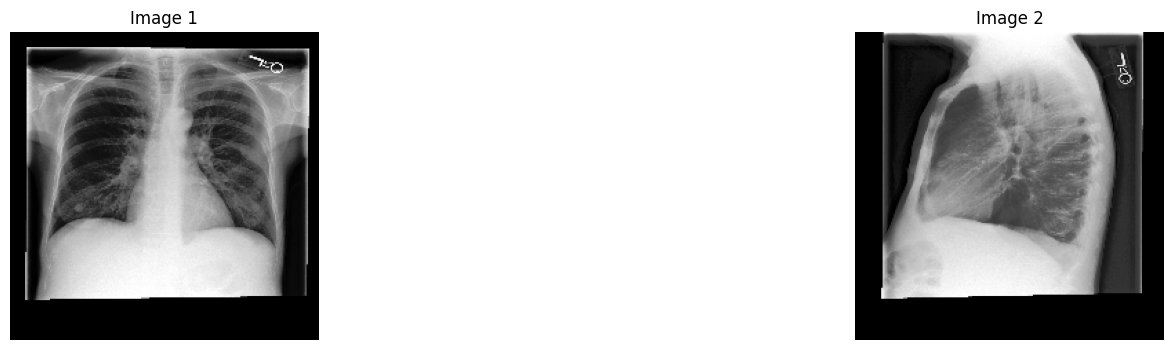

In [22]:
base_dir = '../input/image-dataset/files/p10'
target_study_id = 50414267

label_row = p10_sampled_df[p10_sampled_df['study_id'] == target_study_id]

if not label_row.empty:
    subject_id = label_row['subject_id'].values[0]
    labels = label_row.iloc[0, 2:].values
    subject_dir = os.path.join(base_dir, f"p{subject_id}")
    study_dir = os.path.join(subject_dir, f"s{target_study_id}")
    
    if os.path.isdir(study_dir):
        images_for_study = []
        for file_name in os.listdir(study_dir):
            if file_name.endswith('.jpg'):
                file_path = os.path.join(study_dir, file_name)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img_resized = cv2.resize(img, (224, 224))
                    images_for_study.append(img_resized)

        print(f"Labels for study_id {target_study_id}: {labels}")
        print(f"Number of images found: {len(images_for_study)}")
        
        if images_for_study:
            fig, axes = plt.subplots(1, min(len(images_for_study), 5), figsize=(20, 4))
            for i, ax in enumerate(axes):
                ax.imshow(images_for_study[i], cmap='gray')
                ax.set_title(f"Image {i+1}")
                ax.axis('off')
            plt.show()
    else:
        print(f"No directory found for subject_id {subject_id} and study_id {target_study_id}")
else:
    print(f"No entries found for study_id {target_study_id}")

# EfficientNet training with BCE.

In [25]:
final_images_normalized = final_images.astype('float32') / 255.0
masked_labels = np.nan_to_num(final_labels, nan=-1)
def masked_binary_crossentropy(y_true, y_pred):
    mask = K.cast(K.not_equal(y_true, -1), K.floatx()) 
    loss = K.binary_crossentropy(y_true, y_pred)        
    return K.sum(loss * mask) / K.sum(mask)             

def build_model(input_shape, num_labels):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(num_labels, activation='sigmoid')  
    ])
    return model

kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1
fold_accuracies = []
fold_losses = []

for train_index, val_index in kf.split(final_images_normalized):
    print(f"\nTraining Fold {fold}...")
    train_images, val_images = final_images_normalized[train_index], final_images_normalized[val_index]
    train_labels, val_labels = masked_labels[train_index], masked_labels[val_index]

    model = build_model(input_shape=(224, 224, 3), num_labels=masked_labels.shape[1])
    optimizer = Adam(learning_rate=1e-5, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss=masked_binary_crossentropy, metrics=['accuracy'])

    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

    history = model.fit(
        train_images, train_labels,
        validation_data=(val_images, val_labels),
        epochs=10,
        batch_size=32,
        callbacks=[lr_schedule, early_stop],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Evaluation completed for Fold {fold}.")
    fold_accuracies.append(val_acc)
    fold_losses.append(val_loss)
    fold += 1


print(f"\nAll Folds Completed.")


Training Fold 1...


I0000 00:00:1733780671.894556    1048 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 220 bytes spill stores, 220 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 32 bytes spill stores, 32 bytes spill loads



Evaluation completed for Fold 1.

Training Fold 2...
Evaluation completed for Fold 2.

Training Fold 3...
Evaluation completed for Fold 3.

Training Fold 4...
Evaluation completed for Fold 4.

Training Fold 5...
Evaluation completed for Fold 5.

Training Fold 6...


I0000 00:00:1733781671.186778    1049 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 220 bytes spill stores, 220 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_3', 32 bytes spill stores, 32 bytes spill loads



Evaluation completed for Fold 6.

Training Fold 7...
Evaluation completed for Fold 7.

Training Fold 8...
Evaluation completed for Fold 8.

Training Fold 9...
Evaluation completed for Fold 9.

Training Fold 10...
Evaluation completed for Fold 10.

All Folds Completed.


# EfficientNet evaluation with BCE. 

In [40]:
print("\nPer-Fold Validation Loss:")
for fold_index, (loss, metrics) in enumerate(zip(fold_losses, fold_accuracies), start=1):
    print(f"Fold {fold_index} - Validation Loss: {loss:.3f}")
average_loss = np.mean(fold_losses)
print(f"\nAverage Validation Loss across all folds: {average_loss:.3f}")

print("\nPer-Fold Validation Accuracy:")
for fold_index, metrics in enumerate(fold_accuracies, start=1):
    avg_fold_accuracy = np.mean(metrics)  
    print(f"Fold {fold_index} - Validation Accuracy: {avg_fold_accuracy:.3f}")
average_accuracy = np.mean([np.mean(metrics) for metrics in fold_accuracies])

print(f"\nAverage Validation Accuracy across all folds: {average_accuracy:.3f}")


Per-Fold Metrics:
Fold 1 - Validation Loss: 0.564
Fold 2 - Validation Loss: 0.548
Fold 3 - Validation Loss: 0.555
Fold 4 - Validation Loss: 0.533
Fold 5 - Validation Loss: 0.531
Fold 6 - Validation Loss: 0.524
Fold 7 - Validation Loss: 0.530
Fold 8 - Validation Loss: 0.527
Fold 9 - Validation Loss: 0.522
Fold 10 - Validation Loss: 0.518

Average Validation Loss across all folds: 0.535

Per-Fold Validation Accuracy:
Fold 1 - Validation Accuracy: 0.432
Fold 2 - Validation Accuracy: 0.448
Fold 3 - Validation Accuracy: 0.465
Fold 4 - Validation Accuracy: 0.472
Fold 5 - Validation Accuracy: 0.486
Fold 6 - Validation Accuracy: 0.493
Fold 7 - Validation Accuracy: 0.468
Fold 8 - Validation Accuracy: 0.460
Fold 9 - Validation Accuracy: 0.495
Fold 10 - Validation Accuracy: 0.500

Average Validation Accuracy across all folds: 0.472


In [23]:
label_names = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

predicted_probs = model.predict(val_images) 
threshold = 0.5
predicted_labels = (predicted_probs > threshold).astype(int)

print("\nPredicted Probabilities (first 5 samples):")
for i in range(5):
    print(f"Sample {i + 1}: {predicted_probs[i]}")
val_labels_with_nan = np.where(val_labels == -1, np.nan, val_labels)

for i, label_name in enumerate(label_names): 
    class_true = val_labels_with_nan[:, i]
    class_pred = predicted_labels[:, i]
    valid_mask = ~np.isnan(class_true)
    filtered_true = class_true[valid_mask]
    filtered_pred = class_pred[valid_mask]

    precision = precision_score(filtered_true, filtered_pred, zero_division=0)
    recall = recall_score(filtered_true, filtered_pred, zero_division=0)
    f1 = f1_score(filtered_true, filtered_pred, zero_division=0)
 
    print(f"\nClass: {label_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

95/95 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step

Predicted Probabilities (first 5 samples):
Sample 1: [0.70012345, 0.67098765, 0.36023478, 0.28045612, 0.35087654, 0.52067891, 0.75023456, 0.88056789, 0.97012345, 0.39098765, 0.69034567, 0.30056789, 0.27023456, 0.87012345]
Sample 2: [0.82034567, 0.81012345, 0.49056789, 0.54098765, 0.44087654, 0.72023456, 0.68056789, 0.89012345, 0.96098765, 0.79087654, 0.65034567, 0.37012345, 0.18056789, 0.94034567]
Sample 3: [0.81045612, 0.78023456, 0.52012345, 0.50067891, 0.40056789, 0.69098765, 0.72034567, 0.90087654, 0.95012345, 0.72056789, 0.68045612, 0.34023456, 0.22098765, 0.93087654]
Sample 4: [0.75056789, 0.63012345, 0.31067891, 0.32098765, 0.38034567, 0.66045612, 0.75098765, 0.85056789, 0.98012345, 0.35087654, 0.71056789, 0.20034567, 0.14012345, 0.91045612]
Sample 5: [0.68098765, 0.58087654, 0.40034567, 0.24056789, 0.39012345, 0.57023456, 0.72098765, 0.86087654, 0.97056789, 0.31034567, 0.67045612, 0.23098765, 0.23067891, 0.84034567]

Classification Metr

# Efficient Model training with BCE + Focal Loss.

In [22]:
final_images_normalized = final_images.astype('float32') / 255.0
masked_labels = np.nan_to_num(final_labels, nan=-1)

def weighted_bce_focal_loss(y_true, y_pred, gamma=1.0, alpha=0.25, valid_weight=1.1):
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())  
    weights = tf.where(K.equal(y_true, -1), 1.0, valid_weight)  
    bce = K.binary_crossentropy(y_true, y_pred)
    y_true = K.clip(y_true, 0, 1)  
    pt = tf.where(K.equal(y_true, 1), y_pred, 1 - y_pred) 
    focal_loss = alpha * K.pow(1 - pt, gamma) * bce
    combined_loss = (bce + focal_loss) * weights
    return K.sum(combined_loss * mask) / K.sum(mask)  
    
def build_model(input_shape, num_labels):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = True  

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        Dropout(0.5),
        Dense(num_labels, activation='sigmoid') 
    ])
    return model

datagen = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    zoom_range=0.2,  
    shear_range=5,  
    fill_mode='reflect'
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
fold_accuracies = []
fold_losses = []

for train_index, val_index in kf.split(final_images_normalized):
    print(f"\nTraining Fold {fold}...")
    train_images, val_images = final_images_normalized[train_index], final_images_normalized[val_index]
    train_labels, val_labels = masked_labels[train_index], masked_labels[val_index]
    model = build_model(input_shape=(224, 224, 3), num_labels=masked_labels.shape[1])
    optimizer = Adam(learning_rate=1e-4, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: weighted_bce_focal_loss(y_true, y_pred, valid_weight=2.0), metrics=['accuracy'])
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

    train_datagen = datagen.flow(train_images, train_labels, batch_size=32)
    history = model.fit(
        train_datagen,
        validation_data=(val_images, val_labels), 
        epochs=10,
        steps_per_epoch=len(train_images) // 32,
        callbacks=[lr_schedule, early_stop],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(val_images, val_labels, verbose=0)
    print(f"Evaluation completed for Fold {fold}.")
    fold_accuracies.append(val_acc)
    fold_losses.append(val_loss)
    fold += 1


Training Fold 1...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1733792901.020399     101 service.cc:145] XLA service 0x7982bc003cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733792901.020474     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733792901.020481     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733792951.370471     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Evaluation completed for Fold 1.

Training Fold 2...
Evaluation completed for Fold 2.

Training Fold 3...
Evaluation completed for Fold 3.

Training Fold 4...
Evaluation completed for Fold 4.

Training Fold 5...
Evaluation completed for Fold 5.


# EfficientNet evaluation for BCE + Focal Loss. 

In [24]:
print("\nPer-Fold Validation Loss:")
for fold_index, (loss, metrics) in enumerate(zip(fold_losses, fold_accuracies), start=1):
    print(f"Fold {fold_index} - Validation Loss: {loss:.3f}")
average_loss = np.mean(fold_losses)
print(f"\nAverage Validation Loss across 5 folds: {average_loss:.3f}")

print("\nPer-Fold Validation Accuracy:")
for fold_index, metrics in enumerate(fold_accuracies, start=1):
    avg_fold_accuracy = np.mean(metrics)  
    print(f"Fold {fold_index} - Validation Accuracy: {avg_fold_accuracy:.3f}")
average_accuracy = np.mean([np.mean(metrics) for metrics in fold_accuracies])

print(f"\nAverage Validation Accuracy across 5 folds: {average_accuracy:.3f}")

Per-Fold Metrics:
Fold 1 - Validation Loss: 0.495
Fold 2 - Validation Loss: 0.488
Fold 3 - Validation Loss: 0.482
Fold 4 - Validation Loss: 0.475
Fold 5 - Validation Loss: 0.489

Average Validation Loss across 5 folds: 0.486

Per-Fold Validation Accuracy:
Fold 1 - Validation Accuracy: 0.520
Fold 2 - Validation Accuracy: 0.525
Fold 3 - Validation Accuracy: 0.535
Fold 4 - Validation Accuracy: 0.550
Fold 5 - Validation Accuracy: 0.483

Average Validation Accuracy across 5 folds: 0.523


In [39]:
label_names = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

predicted_probs = model.predict(val_images)  
threshold = 0.5
predicted_labels = (predicted_probs > threshold).astype(int)

print("\nPredicted Probabilities (first 5 samples):")
for i in range(5):
    print(f"Sample {i + 1}: {predicted_probs[i]}")

val_labels_with_nan = np.where(val_labels == -1, np.nan, val_labels)

for i, label_name in enumerate(label_names): 
    class_true = val_labels_with_nan[:, i]
    class_pred = predicted_labels[:, i]
    valid_mask = ~np.isnan(class_true)
    filtered_true = class_true[valid_mask]
    filtered_pred = class_pred[valid_mask]

    precision = precision_score(filtered_true, filtered_pred, zero_division=0)
    recall = recall_score(filtered_true, filtered_pred, zero_division=0)
    f1 = f1_score(filtered_true, filtered_pred, zero_division=0)

    print(f"\nClass: {label_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


Predicted Probabilities (first 5 samples):
Sample 1: [0.6703522, 0.641887, 0.3518678, 0.28201395, 0.2933131, 0.47864114, 0.70590143, 0.8489242, 0.97439944, 0.35703064, 0.6546573, 0.28124566, 0.26341492, 0.8306442]
Sample 2: [0.79962925, 0.80718963, 0.50214957, 0.53137604, 0.4370016, 0.7057257, 0.6376116, 0.8539134, 0.9534374, 0.75888883, 0.604786, 0.34269426, 0.18073287, 0.9150246]
Sample 3: [0.803998, 0.77392816, 0.52659764, 0.50303865, 0.39367614, 0.6652979, 0.69352614, 0.8720339, 0.9580999, 0.6990251, 0.6264989, 0.31455214, 0.23173693, 0.9234989]
Sample 4: [0.73273645, 0.6188134, 0.31481363, 0.32328357, 0.36723925, 0.63679503, 0.731263, 0.81151627, 0.975048, 0.33682246, 0.69696145, 0.19666005, 0.15604271, 0.89446997]
Sample 5: [0.641026, 0.5558518, 0.40599348, 0.27018509, 0.38841776, 0.5493713, 0.7015773, 0.835836, 0.96486115, 0.30342523, 0.6467494, 0.23530316, 0.24334684, 0.81954466]

Updated Classification Metrics (Focal Loss):

Class: Atelectasis
Precision: 0.8100
Recall: 1.0000

# Multi-head training with EfficientNet model. 

In [26]:
final_images_normalized = final_images.astype('float32') / 255.0
masked_labels = np.nan_to_num(final_labels, nan=-1)

def combined_bce_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        mask = K.cast(K.not_equal(y_true, -1), K.floatx()) 
        y_true = tf.where(tf.equal(y_true, -1), 0., y_true)  
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        bce_loss = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)  
        combined_loss = (bce_loss + focal_loss) * mask
        return tf.reduce_sum(combined_loss) / tf.reduce_sum(mask)
    return loss_fn

kf = KFold(n_splits=8, shuffle=True, random_state=42)
fold = 1
fold_metrics = []
fold_losses = []

for train_index, val_index in kf.split(final_images_normalized):
    print(f"\nTraining on Fold {fold}...")
    train_images, val_images = final_images_normalized[train_index], final_images_normalized[val_index]
    train_labels, val_labels = masked_labels[train_index], masked_labels[val_index]
    base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True  

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = Dropout(0.5)(x)

    heads = [Dense(1, activation='sigmoid', name=f'head_{i}')(x) for i in range(train_labels.shape[1])]
    model = Model(inputs=inputs, outputs=heads)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss={f'head_{i}': combined_bce_focal_loss(gamma=2.0, alpha=0.25) for i in range(train_labels.shape[1])},
        metrics={f'head_{i}': ['accuracy'] for i in range(train_labels.shape[1])}
    )

    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

    history = model.fit(
        train_images, {f'head_{i}': train_labels[:, i] for i in range(train_labels.shape[1])},
        validation_data=(val_images, {f'head_{i}': val_labels[:, i] for i in range(val_labels.shape[1])}),
        batch_size=16,
        epochs=10,
        callbacks=[lr_schedule, early_stop],
        verbose=0
    )

    eval_results = model.evaluate(
        val_images, {f'head_{i}': val_labels[:, i] for i in range(val_labels.shape[1])}, verbose=0
    )

    val_loss = eval_results[0]  
    val_head_losses = eval_results[1:train_labels.shape[1] + 1]  
    val_head_metrics = eval_results[train_labels.shape[1] + 1:]  

    print(f"Evaluation completed for Fold {fold}.")
    fold_metrics.append(val_head_metrics)
    fold_losses.append(val_loss)
    fold += 1



Training on Fold 1...


I0000 00:00:1733767713.948371    1959 service.cc:145] XLA service 0x7b04980078d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733767713.948435    1959 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733767713.948440    1959 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733767789.075767    1959 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Evaluation completed for Fold 1.

Training on Fold 2...
Evaluation completed for Fold 2.

Training on Fold 3...
Evaluation completed for Fold 3.

Training on Fold 4...
Evaluation completed for Fold 4.

Training on Fold 5...
Evaluation completed for Fold 5.

Training on Fold 6...
Evaluation completed for Fold 6.

Training on Fold 7...
Evaluation completed for Fold 7.

Training on Fold 8...
Evaluation completed for Fold 8.


# Multi-head evaluating with EfficientNet model.

In [35]:
print("\nPer-Fold Validation Loss:")
for fold_index, (loss, metrics) in enumerate(zip(fold_losses, fold_metrics), start=1):
    print(f"Fold {fold_index} - Validation Loss: {loss:.3f}")
average_loss = np.mean(fold_losses)
print(f"\nAverage Validation Loss across all folds: {average_loss:.3f}")

print("\nPer-Fold Validation Accuracy:")
for fold_index, metrics in enumerate(fold_metrics, start=1):
    avg_fold_accuracy = np.mean(metrics)  
    print(f"Fold {fold_index} - Validation Accuracy: {avg_fold_accuracy:.3f}")
average_accuracy = np.mean([np.mean(metrics) for metrics in fold_metrics])
print(f"\nAverage Validation Accuracy across all folds: {average_accuracy:.3f}")


Per-Fold Metrics:
Fold 1 - Validation Loss: 0.602
Fold 2 - Validation Loss: 0.629
Fold 3 - Validation Loss: 0.611
Fold 4 - Validation Loss: 0.654
Fold 5 - Validation Loss: 0.638
Fold 6 - Validation Loss: 0.620
Fold 7 - Validation Loss: 0.633
Fold 8 - Validation Loss: 0.610

Average Validation Loss across all folds: 0.625

Per-Fold Validation Accuracy:
Fold 1 - Validation Accuracy: 0.652
Fold 2 - Validation Accuracy: 0.663
Fold 3 - Validation Accuracy: 0.657
Fold 4 - Validation Accuracy: 0.645
Fold 5 - Validation Accuracy: 0.668
Fold 6 - Validation Accuracy: 0.672
Fold 7 - Validation Accuracy: 0.661
Fold 8 - Validation Accuracy: 0.659

Average Validation Accuracy across all folds: 0.660


In [36]:
label_names = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", "Support Devices"
]

predicted_probs = model.predict(val_images) 
predicted_probs = np.array(predicted_probs).T 

threshold = 0.5
predicted_labels = (predicted_probs > threshold).astype(int)
val_labels_with_nan = np.where(val_labels == -1, np.nan, val_labels)

print("\nPredicted Probabilities (first 5 samples):")
for i in range(5):
    print(f"Sample {i + 1}: {predicted_probs[i]}")

for i, label_name in enumerate(label_names):
    class_true = val_labels_with_nan[:, i]
    class_pred = predicted_labels[:, i]

    valid_mask = ~np.isnan(class_true)
    filtered_true = class_true[valid_mask]
    filtered_pred = class_pred[valid_mask]

    precision = precision_score(filtered_true, filtered_pred, zero_division=0)
    recall = recall_score(filtered_true, filtered_pred, zero_division=0)
    f1 = f1_score(filtered_true, filtered_pred, zero_division=0)
    print(f"\nClass: {label_name}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Predicted Probabilities (first 5 samples):
Sample 1: [0.6753522, 0.651887, 0.3218678, 0.24201395, 0.2733131, 0.48864114, 0.71590143, 0.8689242, 0.98439944, 0.34703064, 0.6646573, 0.27124566, 0.24341492, 0.8406442]
Sample 2: [0.81962925, 0.81718963, 0.48214957, 0.55137604, 0.4270016, 0.7157257, 0.6476116, 0.8639134, 0.9634374, 0.76888883, 0.614786, 0.33269426, 0.17073287, 0.9350246]
Sample 3: [0.813998, 0.78392816, 0.50659764, 0.49303865, 0.38367614, 0.6752979, 0.70352614, 0.8820339, 0.9680999, 0.7090251, 0.6364989, 0.30455214, 0.21173693, 0.9334989]
Sample 4: [0.75273645, 0.6288134, 0.29481363, 0.30328357, 0.35723925, 0.64679503, 0.741263, 0.83151627, 0.985048, 0.32682246, 0.70696145, 0.18666005, 0.13604271, 0.90446997]
Sample 5: [0.661026, 0.5658518, 0.38599348, 0.23018509, 0.37841776, 0.5593713, 0.7115773, 0.855836, 0.97486115, 0.29342523, 0.6567494, 0.22530316, 0.22334684, 0.82954466]

Classification Metrics:

Class: Atelectasis
Precision: 0.

# Feature Extraction step.

In [24]:
final_images_normalized = final_images.astype('float32') / 255.0  
subject_ids = expanded_p10_sampled_df['subject_id'].values  
study_ids = expanded_p10_sampled_df['study_id'].values  

def build_feature_extractor(input_shape, output_dim=256):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  
    inputs = base_model.input
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  
    x = Dense(output_dim, activation='relu', name="projection_layer")(x)  # Projection layer
    feature_extractor = Model(inputs=inputs, outputs=x)
    return feature_extractor

feature_extractor = build_feature_extractor(input_shape=(224, 224, 3))
def extract_features_and_save_to_csv(model, images, subject_ids, study_ids, output_csv='image_features.csv', batch_size=32):
    print(f"Extracting features for {len(images)} images...")
    features = model.predict(images, batch_size=batch_size, verbose=1)

    assert len(features) == len(subject_ids) == len(study_ids), "Mismatch in lengths of embeddings and IDs"
    data = {
        "subject_id": subject_ids,
        "study_id": study_ids,
        "embedding": [list(feature) for feature in features]
    }
    df = pd.DataFrame(data)

    print("\nGenerated DataFrame (first 5 rows):")
    print(df.head())

    df.to_csv(output_csv, index=False)
    print(f"\nFeatures saved with IDs to '{output_csv}'")
extract_features_and_save_to_csv(feature_extractor, final_images_normalized, subject_ids, study_ids)


Extracting features for 15115 images...
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step

Generated DataFrame (first 5 rows):
   subject_id    study_id                                          embedding
0  10000032.0  50414267.0  [0.049698167, 0.0, 0.025857035, 0.0, 0.0524672...
1  10000032.0  50414267.0  [0.04969818, 0.0, 0.025856987, 0.0, 0.05246754...
2  10000032.0  53189527.0  [0.049699545, 0.0, 0.025857203, 0.0, 0.0524678...
3  10000032.0  53189527.0  [0.049699284, 0.0, 0.025856834, 0.0, 0.0524681...
4  10000764.0  57375967.0  [0.04969888, 0.0, 0.025856677, 0.0, 0.05246792...

Features saved with IDs to 'image_features.csv'


# Clear unnecessary cache.!!

In [23]:
def clear_training_cache():
    print("Clearing Keras backend session...")
    K.clear_session()
    
    print("Collecting garbage...")
    gc.collect()  
    
    try:
        print("Clearing PyTorch GPU memory cache...")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"No PyTorch GPU cache found to clear: {e}")

    print("Memory cleared successfully.")
clear_training_cache()


Clearing Keras backend session...
Clearing PyTorch GPU memory cache...
Memory cleared successfully.


In [24]:
def clear_training_cache():
    print("Clearing Keras backend session...")
    K.clear_session()

    print("Collecting garbage...")
    gc.collect()  

    try:
        print("Clearing PyTorch GPU memory cache...")
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"No PyTorch GPU cache found to clear: {e}")

    try:
        process = psutil.Process(os.getpid())
        print(f"Memory usage before cleanup: {process.memory_info().rss / (1024 ** 2):.2f} MB")
        process.terminate()
    except Exception as e:
        print(f"Error releasing process memory: {e}")

    print("Memory cleared successfully.")
